0/1635


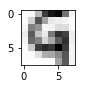

200/1635


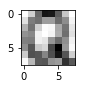

400/1635


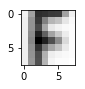

600/1635


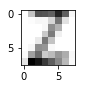

800/1635


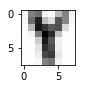

1000/1635


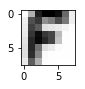

1200/1635


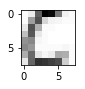

1400/1635


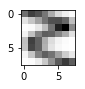

1600/1635


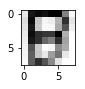

In [3]:
from os.path import basename 
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.filters import gaussian, threshold_otsu
from skimage.restoration import denoise_tv_chambolle
from skimage.color import rgb2gray
from skimage.exposure import rescale_intensity
import warnings
warnings.filterwarnings("ignore")

img_paths = glob("./input/*.png")

keys = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M",
        "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]
values = list(range(len(keys)))
label_dict = dict(zip(keys, values))

imgs = []
labels = []

for i, path in enumerate(img_paths):
    # ------------ 1 ------------
    img = plt.imread(path)
    # ------------ 2 ------------
    img = denoise_tv_chambolle(img, weight = 0.1, multichannel = True, n_iter_max = 10)
    # ------------ 3 ------------
    img = rgb2gray(img)
    # ------------ 4 ------------
    try:
        thresh = threshold_otsu(img)
    except:
        thresh = 0.5
    img = (img > thresh).astype(int)
    # ------------ 5 & 6------------
    black_idx = np.argwhere(img == 0)
    x_start = min(black_idx[:, 1])
    x_end = max(black_idx[:, 1])
    y_start = min(black_idx[:, 0]) 
    y_end = max(black_idx[:, 0])
    h = np.abs(y_start - y_end)
    w = np.abs(x_start - x_end)
    new_hw = max(h, w)
    if new_hw == h:
        padding = np.abs(w - new_hw) // 2
        x_start = max(0, x_start - padding)
        x_end = min(img.shape[1], x_end + padding)
        img = img[y_start:y_end, x_start:x_end]
    else:
        padding = np.abs(h - new_hw) // 2
        y_start = max(0, y_start - padding)
        y_end = min(img.shape[0], y_end + padding)
        img = img[y_start:y_end, x_start:x_end]
    # ------------ 7 ------------
    img[img == 1] = 255
    img = gaussian(img, sigma = 5, preserve_range = True)
    img = img.astype(int)
    # ------------ 8 ------------
    img = resize(img, (8, 8))
    # ------------ 9 ------------
    img = rescale_intensity(img, out_range = (0, 16))   
    # ------------ Save ------------
    imgs.append(img)
    label_key = basename(path)[0]
    labels.append(label_dict[label_key])
    # ------------ Show progress ------------
    if i % 200 == 0:
        print(f"{i}/{len(img_paths)}")
        plt.figure(figsize = (1, 1))
        plt.imshow(imgs[i], cmap = "gray")
        plt.show()

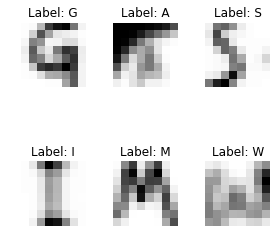

In [7]:
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

values = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L","M",
          "N", "O","P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]
keys = list(range(len(values)))
label_dict = dict(zip(keys, values))

plt.figure(figsize = (4, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(imgs[i], cmap = "gray")
    plt.title(f"Label: {label_dict[labels[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [9]:
# reshape every array in list from (8, 8) to (64,)
imgs = [array.reshape(-1) for array in imgs]

# convert list to (1635, 64) array
imgs = np.asarray(imgs)

imgs = np.nan_to_num(imgs)

In [10]:
train, test, labels_train, labels_test = train_test_split(
    imgs,
    labels,
    test_size = 0.2,
    shuffle = True
)

model = svm.SVC(gamma = 0.001)
model.fit(train, labels_train)
preds = model.predict(test)

print(classification_report(labels_test, preds))
print(confusion_matrix(labels_test, preds))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.79      0.92      0.85        12
           2       1.00      0.80      0.89        10
           3       0.89      0.89      0.89         9
           4       0.92      0.86      0.89        14
           5       0.78      0.78      0.78         9
           6       0.92      0.69      0.79        16
           7       1.00      0.67      0.80        21
           8       0.62      0.83      0.71        12
           9       0.94      0.80      0.86        20
          10       0.93      0.88      0.90        16
          11       0.52      0.80      0.63        15
          12       0.55      0.75      0.63         8
          13       0.60      0.69      0.64        13
          14       0.93      0.88      0.90        16
          15       0.93      0.72      0.81        18
          16       1.00      0.55      0.71        11
          17       0.80    

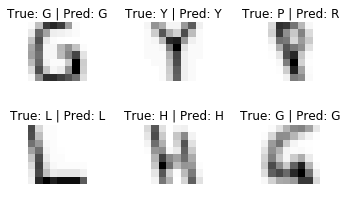

In [18]:
plt.figure(figsize = (5, 3))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(test[i, :].reshape((8, 8)), cmap = "gray")
    plt.title(f"True: {label_dict[labels_test[i]]} | Pred: {label_dict[preds[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()